# Long Short Term Memory Networks for IoT Prediction

RNNs and LSTM models are very popular neural network architectures when working with sequential data, since they both carry some "memory" of previous inputs when predicting the next output. In this assignment we will continue to work with the Household Electricity Consumption dataset and use an LSTM model to predict the Global Active Power (GAP) from a sequence of previous GAP readings. You will build one model following the directions in this notebook closely, then you will be asked to make changes to that original model and analyze the effects that they had on the model performance. You will also be asked to compare the performance of your LSTM model to the linear regression predictor that you built in last week's assignment.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 

In [55]:
import keras # used to build CNN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0 # set the hash seed for numpy generated random numbers

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model #
from keras.layers import Dense, Dropout, LSTM, Activation, Conv1D
from keras.utils import pad_sequences

In [56]:
#use this cell to import additional libraries or define helper functions
from sklearn.model_selection import train_test_split


## Load and prepare your data

We'll once again be using the cleaned household electricity consumption data from the previous two assignments. I recommend saving your dataset by running df.to_csv("filename") at the end of assignment 2 so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

Unlike when using Linear Regression to make our predictions for Global Active Power (GAP), LSTM requires that we have a pre-trained model when our predictive software is shipped (the ability to iterate on the model after it's put into production is another question for another day). Thus, we will train the model on a segment of our data and then measure its performance on simulated streaming data another segment of the data. Our dataset is very large, so for speed's sake, we will limit ourselves to 1% of the entire dataset.

**TODO: Import your data, select the a random 1% of the dataset, and then split it 80/20 into training and validation sets (the test split will come from the training data as part of the tensorflow LSTM model call). HINT: Think carefully about how you do your train/validation split--does it make sense to randomize the data?**

In [57]:
#Load your data into a pandas dataframe here
df = pd.read_csv('../household_power_clean.csv')

In [58]:
#create your training and validation sets here
# extract 1% of data

#take random data subset
subset_df = df.head(int(len(df) * 0.01))

#split data subset 80/20 for train/validation using sklearn to avoid data overlap

# train_df = subset_df.sample(frac=0.8, random_state=42)
# val_df = subset_df.sample(frac=0.2, random_state=42)
train_df, val_df = train_test_split(subset_df, test_size=0.2, shuffle=False, random_state=42)


In [59]:
#reset the indices for cleanliness
train_df = train_df.reset_index()
val_df = val_df.reset_index()

Next we need to create our input and output sequences. In the lab session this week, we used an LSTM model to make a binary prediction, but LSTM models are very flexible in what they can output: we can also use them to predict a single real-numbered output (we can even use them to predict a sequence of outputs). Here we will train a model to predict a single real-numbered output such that we can compare our model directly to the linear regression model from last week.

**TODO: Create a nested list structure for the training data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output**

In [60]:
# initialize lists to hold the input sequences and labels
seq_arrays = [] #sequence of GAP readings
seq_labs = [] # sequence of labels

In [61]:
# we'll start out with a 30 minute input sequence and a 5 minute predictive horizon
# we don't need to work in seconds this time, since we'll just use the indices instead of a unix timestamp
seq_length = 30  # input sequence = timesteps = 30 minutes
ph = 5

feat_cols = ['Global_active_power']

#create list of sequence length GAP readings
for i in range(len(train_df) - seq_length - ph):
    seq = train_df[feat_cols][i:i+seq_length]
    seq_arrays.append(seq)
    seq_labs.append(train_df['Global_active_power'][i + seq_length + ph - 1])
#convert to numpy arrays and floats to appease keras/tensorflow        
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)
print(seq_arrays.shape)
print(seq_labs.shape)


(16358, 30, 1)
(16358,)


In [62]:
# check the shape of the arrays seq_arrays and seq_labs to ensure that they have the correct dimensions
assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,))

In [63]:
# print the shape of the arrays
seq_arrays.shape

(16358, 30, 1)

**Q: What is the function of the assert statements in the above cell? Why do we use assertions in our code?**

A: Assertions help validate that the data structures have the correct shape and size, preventing errors during later stages (like model training). It is used in the code to check the correctness of the shapes of the seq_arrays and seq_labs arrays after they’ve been created.

## Model Training

We will begin with a model architecture very similar to the model we built in the lab session. We will have two LSTM layers, with 5 and 3 hidden units respectively, and we will apply dropout after each LSTM layer. However, we will use a LINEAR final layer and MSE for our loss function, since our output is continuous instead of binary.

**TODO: Fill in all values marked with a ?? in the cell below**

In [64]:
# define path to save model
model_path = 'LSTM_model1.keras'

# build the network
nb_features = 1 # no of features in the input data. only feature is Global_active_power.
nb_out = 1 # no of output feature. predict continous value of Global_active_power.

model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features), #(timesteps, features)
         units=5, #hidden LSTM units, 5 units for the first LSTM layer
         return_sequences=True))
# apply dropout with probability 0.2
model.add(Dropout(0.2)) 

# add second LSTM layer
model.add(LSTM(
          units=3, # 3 units for the first LSTM layer
          return_sequences=False))
model.add(Dropout(0.2))
# dense layer
model.add(Dense(units=1)) #predicting a single continuous value (GAP at the predictive horizon) =output layer 
# activation layer
model.add(Activation('linear')) # linear activation function for continuous value prediction
# compile the model
optimizer = keras.optimizers.Adam(learning_rate = 0.01) # adam optimizer
# loss function is mean squared error
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])
# print model summary
print(model.summary())

# fit the network with the training data
# sequence arrays and sequence labels are the input and output(target) data
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 30, 5)          │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 30, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 3)              │           108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252 (1008.00 B)

 Trainable params: 252 (1008.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
32/32 - 1s - 39ms/step - loss: 2.7089 - mse: 2.7089 - val_loss: 0.1840 - val_mse: 0.1840
Epoch 2/100
32/32 - 0s - 7ms/step - loss: 1.0209 - mse: 1.0209 - val_loss: 0.0936 - val_mse: 0.0936
Epoch 3/100
32/32 - 0s - 6ms/step - loss: 0.8675 - mse: 0.8675 - val_loss: 0.0960 - val_mse: 0.0960
Epoch 4/100
32/32 - 0s - 7ms/step - loss: 0.8219 - mse: 0.8219 - val_loss: 0.0922 - val_mse: 0.0922
Epoch 5/100
32/32 - 0s - 7ms/step - loss: 0.7850 - mse: 0.7850 - val_loss: 0.0958 - val_mse: 0.0958
Epoch 6/100
32/32 - 0s - 8ms/step - loss: 0.7823 - mse: 0.7823 - val_loss: 0.1006 - val_mse: 0.1006
Epoch 7/100
32/32 - 0s - 8ms/step - loss: 0.7645 - mse: 0.7645 - val_loss: 0.1000 - val_mse: 0.1000
Epoch 8/100
32/32 - 0s - 7ms/step - loss: 0.7424 - mse: 0.7424 - val_loss: 0.0982 - val_mse: 0.0982
Epoch 9/100
32/32 - 0s - 8ms/step - loss: 0.7217 - mse: 0.7217 - val_loss: 0.0995 - val_mse: 0.0995
Epoch 10/100
32/32 - 0s - 9ms/step - loss: 0.7186 - mse: 0.7186 - val_loss: 0.1430 - val_mse: 

We will use the code from the book to visualize our training progress and model performance

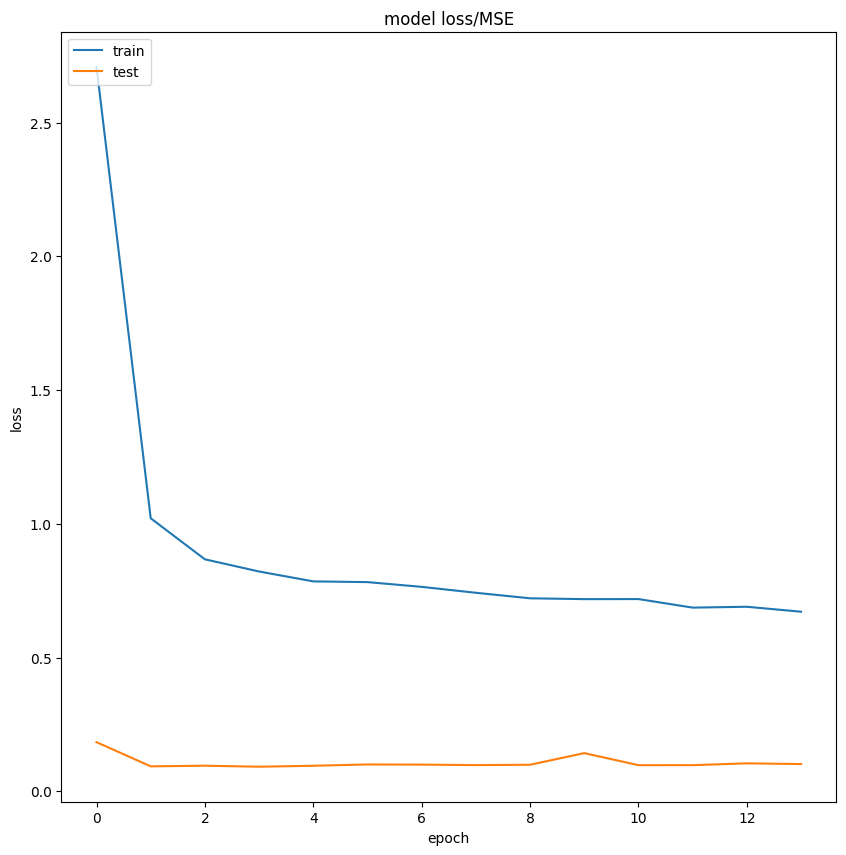

In [65]:
# summarize history for Loss/MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss/MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")


## Validating our model

Now we need to create our simulated streaming validation set to test our model "in production". With our linear regression models, we were able to begin making predictions with only two datapoints, but the LSTM model requires an input sequence of *seq_length* to make a prediction. We can get around this limitation by "padding" our inputs when they are too short.

**TODO: create a nested list structure for the validation data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output. Begin your predictions after only two GAP measurements are available, and check out [this keras function](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) to automatically pad sequences that are too short.**

**Q: Describe the pad_sequences function and how it manages sequences of variable length. What does the "padding" argument determine, and which setting makes the most sense for our use case here?**

A: The pad_sequences function is used to standardize the length of sequences fed into a model to ensure the sequences have consistent dimensions especially variable-length sequences. It works by taking a list of sequences with different lengths as input. The function then pads the sequences to make them all the same length by either adding padding value (default 0) at the beginning(pre) or the end (post) of the sequences.
- The padding argument determines where the padding will be added, pre or post.
- Since we are using a predictive horizon, where the most recent measurements are most important for making predictions, padding at the end (post) makes the most sense. This is because LSTM will be learning patterns based on the most recent data, and we want to ensure the LSTM sees as much of the actual data as possible without interference from the padding at the beginning.

In [66]:

# initialize lists to store validation sequences and labels
val_arrays = [] #sequence of GAP readings
val_labs = [] #labels

#create list of GAP readings starting with a minimum of two readings
seq_length = 30  # input sequence length (30 minutes)
ph = 5           # predictive horizon (5 steps ahead)

# use the pad_sequences function on your input sequences
#create list of sequence length GAP readings
for i in range(len(val_df) - seq_length - ph):
    seq = val_df[feat_cols][i:i+seq_length]
    val_arrays.append(seq)
    val_labs.append(val_df['Global_active_power'][i + seq_length + ph - 1])

# remember that we will later want our datatype to be np.float32 
val_arrays =  np.array(val_arrays, dtype = object).astype(np.float32)  
#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

print(val_arrays.shape)
print(val_labs.shape)


(4064, 30, 1)
(4064,)


We will now run this validation data through our LSTM model and visualize its performance like we did on the linear regression data.

127/127 - 0s - 949us/step - loss: 0.6333 - mse: 0.6333

MSE: 0.6333475708961487
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step


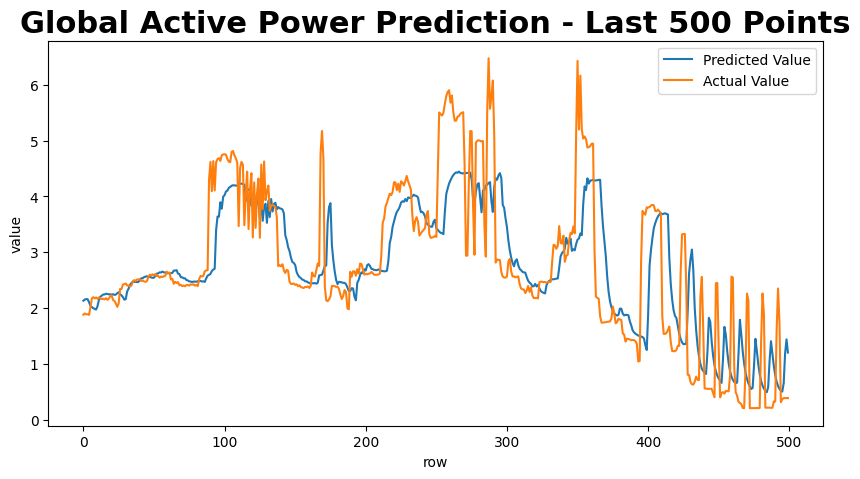

In [67]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the last 500 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

**Q: How did your model perform? What can you tell about the model from the loss curves? What could we do to try to improve the model?**

A: The model performs reasonably well, with the predicted data following the same trend as the actual data but there’s room for improvement in terms of prediction accuracy, especially during sharp transitions. The train loss starts high but drops sharply, which is typical in early training stages. The test loss decreases more gradually, but it stabilizes, suggesting that the model is achieving a reasonable fit to the training data while still improving on unseen data.

**What could we do to try to improve the model?**
- We could increase the dropout rate or add more dropout layers to force the model to generalize better and prevent it from memorizing the training data.
- Adding L2 regularization to the LSTM layers could help the model avoid large weights and overfitting.
- Increase data size to help the model generalize better to unseen data.
- Adjust Learning Rate to a lower rate
- Decreasing the batch size


## Model Optimization

Now it's your turn to build an LSTM-based model in hopes of improving performance on this training set. Changes that you might consider include:

- Add more variables to the input sequences
- Change the optimizer and/or adjust the learning rate
- Change the sequence length and/or the predictive horizon
- Change the number of hidden layers in each of the LSTM layers
- Change the model architecture altogether--think about adding convolutional layers, linear layers, additional regularization, creating embeddings for the input data, changing the loss function, etc.

There isn't any minimum performance increase or number of changes that need to be made, but I want to see that you have tried some different things. Remember that building and optimizing deep learning networks is an art and can be very difficult, so don't make yourself crazy trying to optimize for this assignment.

**Q: What changes are you going to try with your model? Why do you think these changes could improve model performance?**

A: Change the optimizer and/or adjust the learning rate: switching to a more adaptive optimizer  could help stabilize training and achieve better convergence. Adjusting the learning rate can significantly affect the model’s ability to learn. 
- Change the number of hidden layers in each of the LSTM layers: Adding layers can help the model better understand higher-order relationships, especially if there are long-term dependencies in the data. 
- Increase the sequence length: Increasing the sequence length gives the model more data to capture temporal patterns over longer periods of time. A longer sequence might help the model capture seasonal or periodic patterns that shorter sequences may miss.
- Adjust the batch size and epoch: A smaller batch size (e.g., 32 or 64) might make the model more responsive and allow it to generalize better. Too many epochs may lead to overfitting, while too few may result in underfitting. Adjusting epochs to a higher number (e.g., 100) with EarlyStopping might allow the model to train sufficiently without overfitting.


In [78]:
# play with your ideas for optimization here

## input sequence length and label sequence length
seq_length = 60  # input sequence = timesteps = 30 minutes
ph = 5

feat_cols = ['Global_active_power']

seq_arrays = [] #sequence of GAP readings
seq_labs = [] # sequence of labels

#create list of sequence length GAP readings
for i in range(len(train_df) - seq_length - ph):
    seq = train_df['Global_active_power'][i:i+seq_length]
    seq_arrays.append(seq)
    seq_labs.append(train_df['Global_active_power'][i + seq_length + ph - 1])
#    seq_labs.append(train_df[feat_cols][i + seq_length - ph - 2])
#convert to numpy arrays and floats to appease keras/tensorflow        
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)
# define path to save model

model_path = 'LSTM_model1.keras'

# build the network
nb_features = 1 # no of features in the input data. only feature is Global_active_power.
nb_out = 1 # no of output feature. predict continous value of Global_active_power.

model = Sequential()

# add convolutional layer (Optional - for feature extraction)
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(seq_length, len(feat_cols))))
model.add(Dropout(0.2))

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features), #(timesteps, features)
         units=16, #hidden LSTM units, 5 units for the first LSTM layer
         return_sequences=True))
# apply dropout with probability 0.2
model.add(Dropout(0.2))

# add second LSTM layer
model.add(LSTM(
          units=8, # 3 units for the second LSTM layer
          return_sequences=False))

model.add(Dropout(0.2))

#dense layer
model.add(Dense(units=1)) #predicting a single continuous value (GAP at the predictive horizon) =output layer 
# activation layer
model.add(Activation('linear')) # linear activation function for continuous value prediction

# compile the model
optimizer = keras.optimizers.Adam(learning_rate = 0.0001) # adam optimizer 0.01
# loss function is mean squared error
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])
# print model summary
print(model.summary())

# fit the network with the training data
# sequence arrays and sequence labels are the input and output(target) data
history = model.fit(seq_arrays, seq_labs, epochs=30, batch_size=16, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 58, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 58, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 58, 16)         │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 58, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 8)              │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,073 (15.91 KB)

 Trainable params: 4,073 (15.91 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
970/970 - 10s - 10ms/step - loss: 2.0098 - mse: 2.0098 - val_loss: 0.1356 - val_mse: 0.1356
Epoch 2/30
970/970 - 9s - 9ms/step - loss: 0.9125 - mse: 0.9125 - val_loss: 0.1293 - val_mse: 0.1293
Epoch 3/30
970/970 - 9s - 9ms/step - loss: 0.8177 - mse: 0.8177 - val_loss: 0.1098 - val_mse: 0.1098
Epoch 4/30
970/970 - 9s - 9ms/step - loss: 0.7803 - mse: 0.7803 - val_loss: 0.1062 - val_mse: 0.1062
Epoch 5/30
970/970 - 9s - 9ms/step - loss: 0.7356 - mse: 0.7356 - val_loss: 0.1146 - val_mse: 0.1146
Epoch 6/30
970/970 - 9s - 9ms/step - loss: 0.7376 - mse: 0.7376 - val_loss: 0.1124 - val_mse: 0.1124
Epoch 7/30
970/970 - 9s - 9ms/step - loss: 0.7134 - mse: 0.7134 - val_loss: 0.1027 - val_mse: 0.1027
Epoch 8/30
970/970 - 9s - 9ms/step - loss: 0.6955 - mse: 0.6955 - val_loss: 0.1011 - val_mse: 0.1011
Epoch 9/30
970/970 - 9s - 9ms/step - loss: 0.6892 - mse: 0.6892 - val_loss: 0.0963 - val_mse: 0.0963
Epoch 10/30
970/970 - 9s - 9ms/step - loss: 0.6766 - mse: 0.6766 - val_loss: 0.0906 

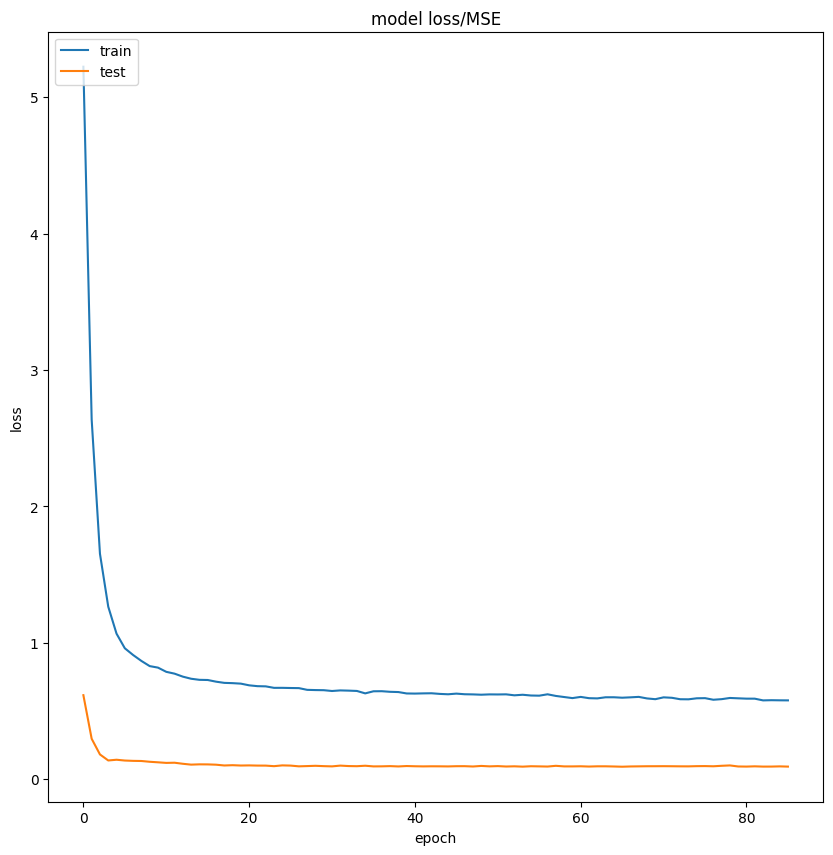

In [69]:
# summarize history for Loss/MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss/MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1_opt.png")


In [75]:

# initialize lists to store validation sequences and labels
val_arrays = [] #sequence of GAP readings
val_labs = [] #labels

#create list of GAP readings starting with a minimum of two readings
seq_length = 30  # input sequence length (30 minutes)
ph = 5           # predictive horizon (5 steps ahead)

# use the pad_sequences function on your input sequences
#create list of sequence length GAP readings
for i in range(len(val_df) - seq_length - ph):
    seq = val_df[feat_cols][i:i+seq_length]
    val_arrays.append(seq)
    val_labs.append(val_df['Global_active_power'][i + seq_length + ph - 1])

# remember that we will later want our datatype to be np.float32 
val_arrays =  np.array(val_arrays, dtype = object).astype(np.float32)  
#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

print(val_arrays.shape)
print(val_labs.shape)


(4064, 30, 1)
(4064,)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_198. Received: the structure of inputs=('*',)
  warnings.warn(


127/127 - 0s - 2ms/step - loss: 0.8392 - mse: 0.8392

MSE: 0.8391706347465515
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


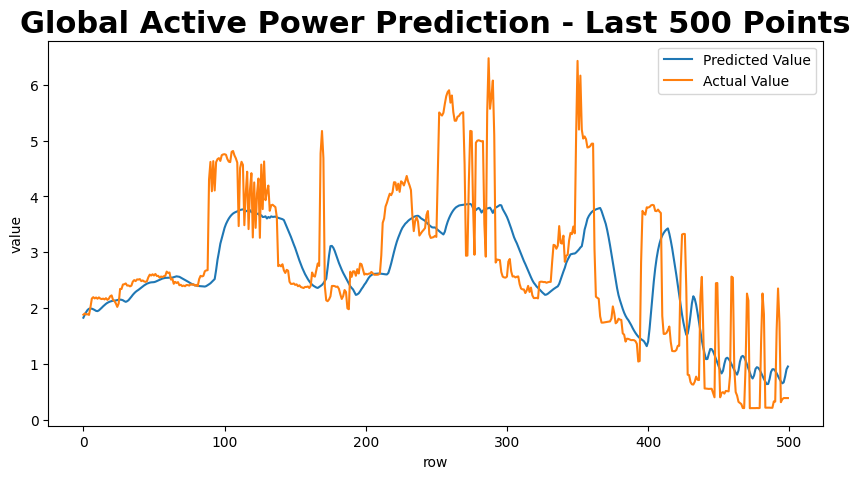

In [76]:
scores_test = model.evaluate([val_arrays], val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the last 500 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

**Q: How did your model changes affect performance on the validation data? Why do you think they were/were not effective? If you were trying to optimize for production, what would you try next?**

A: The model changes, such as reducing the number of LSTM units, adjusting the learning rate, and reducing the batch size slightly improved stability, as seen in the validation loss curve. However, the performance improvement was minimal as evidenced by the gap between the training and validation loss. The reduced learning rate helped to smooth the convergence, but it also slowed the model’s learning, potentially limiting its ability to capture complex patterns.
- For optimization in production, I would try the following:
	1.	Increase the sequence length to capture more context and long-term dependencies.
	2.	Experiment with more regularization techniques although using L2 regularization in this model did not improve the performance, but I would try other regularization methods.
	3.	Use more features (e.g., voltage, time-of-day) to improve model accuracy.
	4.	Fine-tune the optimizer (try SGD with momentum) and learning rate schedules (like learning rate decay).

**Q: How did the models that you built in this assignment compare to the linear regression model from last week? Think about model performance and other IoT device considerations; Which model would you choose to use in an IoT system that predicts GAP for a single household with a 5-minute predictive horizon, and why?**

A: The LSTM models in this assignment outperformed the linear regression model in terms of flexibility to apture complex temporal dependencies in the data. However, the linear regression model was simpler, faster to train, and computationally more efficient, making it more suitable for resource-constrained IoT devices.

For an IoT system predicting GAP for a single household with a 5-minute predictive horizon, Linear Regression would be the better choice due to its lower computational requirements, time-saving, simplicity, and sufficient accuracy for short-term predictions. LSTM models, while more accurate for capturing complex patterns, it overkilled this specific use case and introduced unnecessary complexity and resource demands.